<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Assignment2/svm_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Линейный классификатор SVM (Метод опорных векторов)
Выполните все задания в этом ноутбуке и вспомогательных файлах *.py. Сохраните результат, запакуйте в zip архив и отправьте на почту преподавателю.  
В этом упражнении вам предстоит:  
- реализовать векторизованную функцию потерь (loss) для SVM классификатора; 
- реализовать векторизованную функцию для вычисления аналитического градиента;
- проверить работу функции аналитического градиента, сравнив ее с методом конечных разностей;
- использовать валидационную выборку для настройки скорости обучения (learning rate) и величину регуляризации (regularization strength); 
- найти оптимальные значения весов классификатора с помощью метода градиентного спуска; 
- визуализировать веса классификатора.

In [3]:
# Запустите эту ячейку если вы работаете из Google Colab
# На локальной машине запускать не нужно
!git clone https://github.com/nikitaoltyan/ML-Homework.git
!cd ML-Homework/Assignment2
import os
os.chdir('ML-Homework/Assignment2')
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz 
os.getcwd()

fatal: destination path 'ML-Homework' already exists and is not an empty directory.
--2021-03-12 17:31:49--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  65.0MB/s    in 2.5s    

2021-03-12 17:31:51 (65.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


'/content/ML-Homework/Assignment2'

In [4]:
# Подготовка к работе, импорт библиотек
import random
import numpy as np
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# Изображения нужно отображать в ноутбуке.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Автоматическая перезагрузка модулей из файлов *.py
%load_ext autoreload
%autoreload 2

## Загрузка датасета CIFAR-10 и предварительная подготовка

In [5]:
# Путь к папке с данными
cifar10_dir = 'cifar-10-batches-py'

# Очистим значения переменных, чтобы избежать проблем с излишним потреблением памяти
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Проверим размер входных и выходных векторов.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


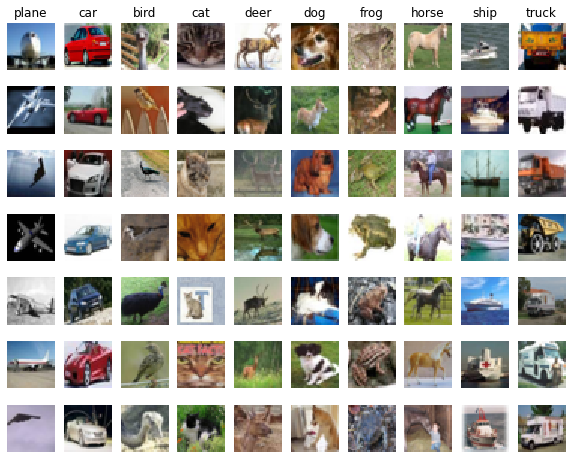

In [6]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Разделим данные на выборки train, val, test

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Для валидации используем подвыборку train
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# На остальных данных из train будем тренировать модель
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Чтобы ускорить разработку, создадим также небольшую dev выборку 
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Для тестирования используем оригинальную выборку test
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [8]:
# Для удобства преобразуем двумерные изображения в одномерные вектора
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Проверим размер полученных данных
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


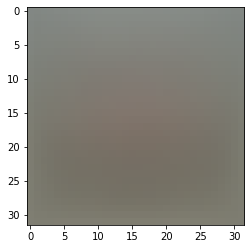

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [9]:
# Нормализуем значения яркости пикселей 
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 

# визуализируем среднюю яркость
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

# Вычтем средние значения яркости
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Добавим к вектору исходных данных фиктивный признак с постоянным значением 1.
# Этот трюк позволит избежать лишних вычислений: x @ W + b  => x' @ W'
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM классификатор (метод опорных векторов)
Основную работу в этом задании предстоит выполнить в файле classifiers/linear_svm.py  
Часть работы уже выполнена в функции svm_loss_naive. Завершите вычисление градиента в этой функции. В функции svm_loss_vectorized предлагается разработать более эффективную (векторизованную) реализацию.

In [11]:
# Вычислим loss с помощью наивной реализации функции потерь:
from linear_svm import svm_loss_naive
import time

# Инициализируем веса значениями близкими, но не равными нулю
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.731617


В текущей реализации градиент функции не вычисляется, возвращаются нули. Реализуйте алгоритм вычисления аналитического градиента в функции svm_loss_naive. Для проверки правильности кода сравните результ вычисления аналитического градиента с методом конечных разностей.

In [ ]:
# После реализации вычисления аналитического градиента 
# запустите код в этой ячейке чтобы сравнить результат с методом конечных разностей

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Градиент, вычисленный аналитически и методом конечных разностей должны совпадать
# с точностью до допустимой погрешности вычислений 
from lib.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Сравним градиенты с учетом регуляризации
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 20.801365 analytic: 2.216882, relative error: 8.073805e-01
numerical: -9.216811 analytic: -5.747290, relative error: 2.318562e-01
numerical: 22.518629 analytic: -0.662320, relative error: 1.000000e+00
numerical: -6.612473 analytic: -2.389216, relative error: 4.691628e-01
numerical: 11.338143 analytic: 6.150719, relative error: 2.966130e-01
numerical: -15.101751 analytic: 2.224222, relative error: 1.000000e+00
numerical: 1.892459 analytic: 18.207430, relative error: 8.116946e-01
numerical: -2.214155 analytic: -4.638042, relative error: 3.537386e-01
numerical: -9.157949 analytic: -0.628938, relative error: 8.714733e-01
numerical: 10.055237 analytic: 4.546138, relative error: 3.773000e-01
numerical: 13.154895 analytic: -9.142698, relative error: 1.000000e+00
numerical: 7.573720 analytic: -8.249722, relative error: 1.000000e+00
numerical: -3.487419 analytic: 3.328163, relative error: 1.000000e+00
numerical: -9.904907 analytic: -1.572105, relative error: 7.260428e-01
numerical: 4

**Вопрос 1**  
Градиент, вычисленный аналитически и методом конечных разностей совпадают неточно. Почему это не считается ошибкой? В какой точке аналитический градиент гарантированно **не совпадет** с методом конечных разностей. Как влияет добавление смещения (отступ, margin) на вычисление функции потерь. Подсказка: loss строго говоря не дифференцируемая функция.  
$\color{blue}{\textit Ответ:}$ *Заполнить здесь*  

In [ ]:
# Теперь реализуйте векторизованное вычисление функции потерь.
# Для прохождения теста в этой ячейке градиент вычислять необязательно.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from lib.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Значения потерь должны совпадать, но векторизованная реализация должна вычисляться быстрее
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.316824e+00 computed in 0.120378s
Vectorized loss: 9.316824e+00 computed in 0.014152s
difference: 0.000000


In [ ]:
# Реализуйте вычисление аналитического градиента dW в функции svm_loss_vectorized

# Градиенты должны совпадать, но векторизованная реализация должна вычисляться быстрее
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# Для вычисления расстояния между двумя матрицами градиентов используем норму Фробениуса
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.120210s
Vectorized loss and gradient: computed in 0.012547s
difference: 2924.568687


## Стохастический градиентный спуск
Мы уже реализовали эффективное вычисление функции потерь и градиента весов. Теперь мы готовы к минимизации потерь методом стохастического градиентного спуска. Реализуйте метод в файле lib/classifiers/linear_classifier.py

In [ ]:
# Реализуйте SGD и проверьте результат 
from lib.classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 408.596395
iteration 100 / 1500: loss 242.420521
iteration 200 / 1500: loss 146.958606
iteration 300 / 1500: loss 90.961450
iteration 400 / 1500: loss 56.647323
iteration 500 / 1500: loss 36.237695
iteration 600 / 1500: loss 23.890293
iteration 700 / 1500: loss 16.758486
iteration 800 / 1500: loss 11.930130
iteration 900 / 1500: loss 9.455425
iteration 1000 / 1500: loss 6.952805
iteration 1100 / 1500: loss 6.502376
iteration 1200 / 1500: loss 5.836521
iteration 1300 / 1500: loss 5.720721
iteration 1400 / 1500: loss 5.321842
That took 10.380759s


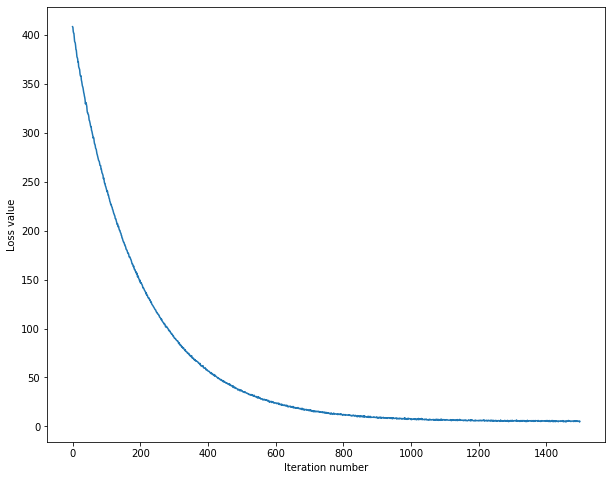

In [ ]:
# Построим график зависимости функции потерь от количества итераций
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Реализуйте функцию LinearSVM.predict и оцените точность предсказания 
# на выборках train и val
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.379347
validation accuracy: 0.369000


In [ ]:
# Используйте валидационную выборку для выбора лучших гиперпараметров 
# (learning rate and regularization strength)
# Добейтесь точности не меньше 0.39 на выборке val.
# Используйте словарь results в котором 
# ключи - кортеж  (learning_rate, regularization_strength)
# значения - (training_accuracy, validation_accuracy)
# Точность вычисляется как отношение числа верно предсказанных классов 
# к объему выборки
results = {}
best_val = -1   
best_svm = None # Лучший экземпляр LinearSVM 

################################################################################
# TODO:                                                                        #
# Напишите код, позволяющий найти лучшее значение гиперпараметров на val       #
# выборке. Для каждой комбинации гиперпараметров обучите классификатор SVM     #
# на train выборке, вычислите точность на выборках train, val и сохраните      #
# результат в словарь results. Лучшее значение точности сохраните в best_val   #
# лучший классификатор - в best_svm                                            #
#                                                                              #
# Подсказка: чтобы уменьшить время обучения, используйте dev подвыборку.       #
# После того, как код будет реализован и отлажен, замените dev на train.       #
################################################################################

# Пример допустимых значений. Можете изменить на свое усмотрение.
learning_rates = [-6.6, -6.15]
regularization_strengths = [4.05, 4.7]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for i in range(128):
    learning_rate = np.power(10, np.random.uniform(learning_rates[0], learning_rates[1]))
    reg = np.power(10, np.random.uniform(regularization_strengths[0], regularization_strengths[1]))
    svm = LinearSVM()
    
    loss_hist = svm.train(X_train, y_train, learning_rate=learning_rate,
                          reg=reg, num_iters=300,
                          batch_size=200, verbose=False)
    
    y_train_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_train_pred == y_train)
    y_val_pred   = svm.predict(X_val)
    val_accuracy   = np.mean(y_val_pred == y_val)
    print(f"For iter {i} accuracy: {val_accuracy}")

    if best_val < val_accuracy:
        best_svm, best_val = svm, val_accuracy
        
    results[(learning_rate, reg)] = (train_accuracy, val_accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Вывод результатов.
"""
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
"""

print('best validation accuracy achieved during cross-validation: %f' % best_val)

For iter 0 accuracy: 0.344
For iter 1 accuracy: 0.341
For iter 2 accuracy: 0.385
For iter 3 accuracy: 0.376
For iter 4 accuracy: 0.367
For iter 5 accuracy: 0.376
For iter 6 accuracy: 0.365
For iter 7 accuracy: 0.369
For iter 8 accuracy: 0.366
For iter 9 accuracy: 0.331
For iter 10 accuracy: 0.352
For iter 11 accuracy: 0.369
For iter 12 accuracy: 0.342
For iter 13 accuracy: 0.306
For iter 14 accuracy: 0.361
For iter 15 accuracy: 0.361
For iter 16 accuracy: 0.375
For iter 17 accuracy: 0.329
For iter 18 accuracy: 0.324
For iter 19 accuracy: 0.374
For iter 20 accuracy: 0.335
For iter 21 accuracy: 0.374
For iter 22 accuracy: 0.317
For iter 23 accuracy: 0.355
For iter 24 accuracy: 0.348
For iter 25 accuracy: 0.354
For iter 26 accuracy: 0.374
For iter 27 accuracy: 0.335
For iter 28 accuracy: 0.344
For iter 29 accuracy: 0.355
For iter 30 accuracy: 0.383
For iter 31 accuracy: 0.36
For iter 32 accuracy: 0.374
For iter 33 accuracy: 0.364
For iter 34 accuracy: 0.348
For iter 35 accuracy: 0.376
For

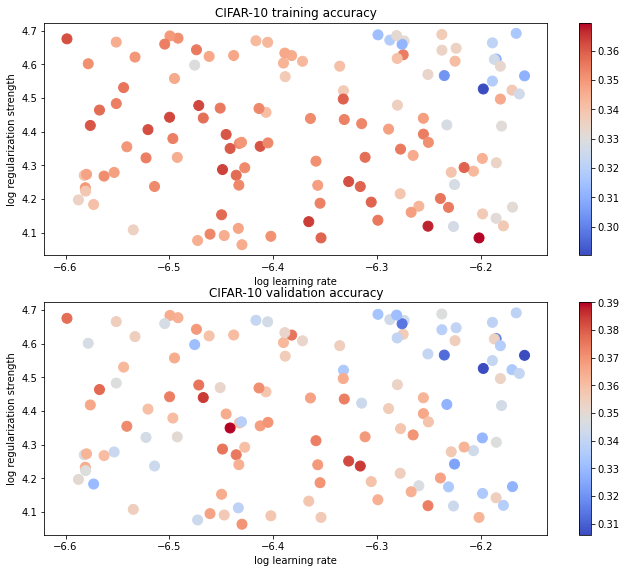

In [ ]:
# Визуализируем результаты кросс-валидации
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# график accuracy на обучении
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# график accuracy на валидации
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Лучший классификатор на тестовых данных
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print(f'linear SVM on raw pixels final test set accuracy: {test_accuracy}')

linear SVM on raw pixels final test set accuracy: 0.355


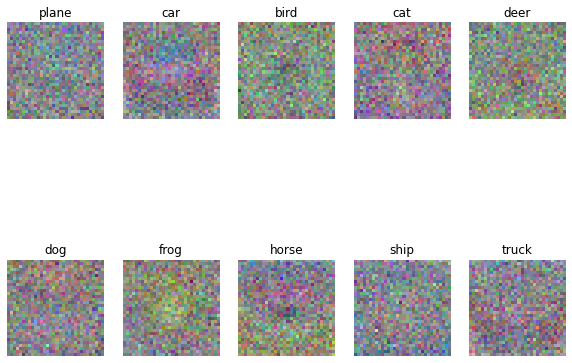

In [ ]:
# Визуализируем веса W для каждого класса
w = best_svm.W[:-1,:] # отбросим bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Масштабируем веса в значения от 0 до 255 для визуализации
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Вопрос 2**  
Опишите, на что похожи веса классификатора SVM. Почему они так выглядят?   
$\color{blue}{\textit Ответ:}$ *Ответ здесь*  

---
# ПОЗДРАВЛЯЕМ!

Это конец задания. Не забудьте сохранить этот ноутбук и файлы linear_svm.py и linear_classifier.py